# **GRAMMATICAL ERROR DETECTION**

It is a task of detecting grammatically incorrect token(s) in a given sequence.
Grammatical error correction is a sequence to sequence problem but grammatical error detection is a token classification problem. 
  

(here, defend the use GED instead of just simple GEC)
  



We have followed an industry standard for approaching data mining problem, known as CRISP process. It stands for Cross-Industry Standard Process. 
Below is the flowchart of CRISP-DM process.


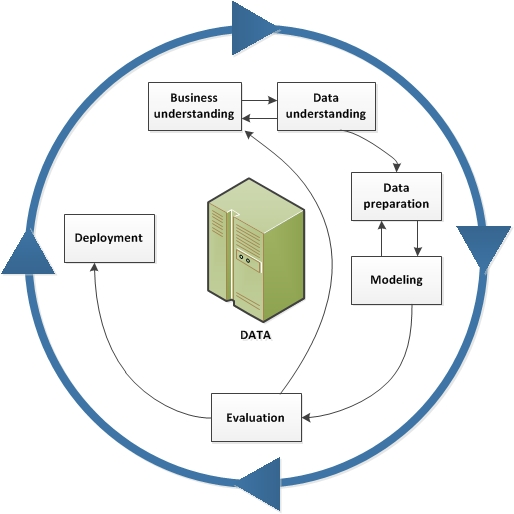
  
  [*source: IBM Documentation*]




1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modelling
5. Evaluation
6. Submission


---

# **1. Business Understanding**

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---

# **2. Data Understanding** 

In [4]:
#loading data
import pandas as pd

df = pd.read_csv("en_fce_train.tsv", delimiter='\t', header=None, names=['token', 'label'])

In [5]:
df.head(20)

,token,label
0,Dear,c
1,Sir,c
2,or,c
3,Madam,c
4,",",c
5,I,c
6,am,c
7,writing,c
8,in,c
9,order,c


In [5]:
df.shape

(454730, 2)

Given dataset has 454730 tokens, each tokens are classified in two categories- *'c'* or *'i'*, standing for *'correct'* and *'incorrect'* respectively

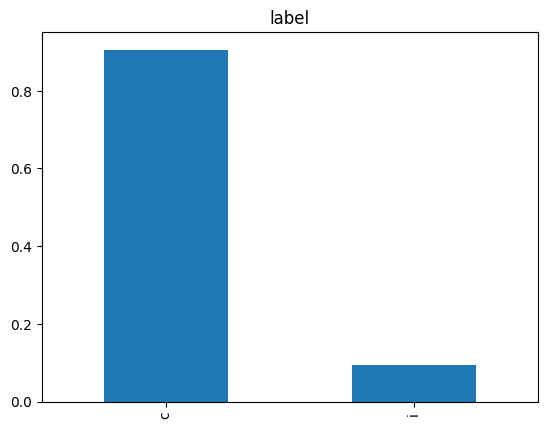

In [6]:
#checking if data is imbalance or not
def imbalance(target_column):
    return (target_column.value_counts()/target_column.value_counts().sum())*100

imbalance(df['label'])

#plotting bar plot of labels
import matplotlib.pyplot as plt
df['label'].value_counts(normalize=True).plot(kind='bar')
plt.title('label')
plt.show()

Data is highly imbalanced in which ~90% of tokens are labelled *'c'*

In [7]:
#columnwise number of missing values 
df.isnull().sum()

token    0
label    0
dtype: int64

No null values in the given dataset


---

# **3. Data Preparation**

Given training data is in the form of:  
token1 -> label1  
token2 -> label2  
token3 -> label3  
...  
  
We want in the form of:  
sentences = [[token1, token2], [token3, token4, token5]...]  
labels = [[label1, label2], [label3, label4, label5]...]

In [8]:
sentences = []
labels = []
unique_labels = set()


temp_sentences = []
temp_labels = []
for index, row in df.iterrows():
  if row["token"] != '.':
    temp_sentences.append(row['token'])
    temp_labels.append(row['label'])
    
  else:
    temp_sentences.append(row['token'])
    temp_labels.append(row['label'])
    
    unique_labels.add(row['label'])
    sentences.append(temp_sentences)
    labels.append(temp_labels)
    temp_labels = []
    temp_sentences = []


In [9]:
print(unique_labels)
print(sentences[0])
print(labels[0])

{'c', 'i'}
['Dear', 'Sir', 'or', 'Madam', ',', 'I', 'am', 'writing', 'in', 'order', 'to', 'express', 'my', 'disappointment', 'about', 'your', 'musical', 'show', '\\"', 'Over', 'the', 'Rainbow', '\\"', '.']
['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'i', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']


In [10]:
# Map each unique label to an integer.
label_map = {'i': 0, 'c': 1}
label_map

{'i': 0, 'c': 1}

In [11]:
print("Number of training sentences: {:,}".format(len(sentences)))

Number of training sentences: 23,069


In [12]:
from transformers import  RobertaForTokenClassification,RobertaTokenizer
import numpy as np

tokenizer = RobertaTokenizer.from_pretrained('MMG/roberta-base-ner-english')

# to record the length of each sequence
lengths = []

for i in sentences:

    # reconstructing the sentence to let BERT decide how to tokenize it
    i = ' '.join(i)

    encoded_sent = tokenizer.encode(i)
       
    lengths.append(len(encoded_sent))

In [13]:
print(encoded_sent)

[0, 166, 697, 11, 10, 650, 8, 793, 30874, 1139, 8, 427, 4, 735, 21, 1687, 10, 13317, 4832, 4600, 10174, 39, 633, 21, 543, 13, 123, 2156, 53, 190, 4851, 21, 5, 872, 9, 39, 8055, 12384, 54, 58, 45, 1220, 7, 972, 123, 25606, 98, 2156, 15, 10, 4520, 1035, 183, 37, 362, 39, 507, 568, 8, 962, 19419, 30, 5, 15073, 61, 21, 19177, 479, 2]


In [14]:
print('Max length: {:,} tokens'.format(max(lengths)))

Max length: 236 tokens


In [15]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:

    sent_str = ' '.join(sent)

    encoded_dict = tokenizer.encode_plus(
                        sent_str,                 
                        add_special_tokens = True, 
                        truncation = True,
                        max_length = 256,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    
    input_ids.append(encoded_dict['input_ids'][0])
    
    attention_masks.append(encoded_dict['attention_mask'][0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
new_labels = []

null_label_id = -100

for sen, orig_labels in zip(input_ids, labels):
  padded_labels = []
  orig_labels_i = 0

  n = len(orig_labels)

  for token_id in sen:
    token_id = token_id.numpy().item()
    if (token_id == tokenizer.pad_token_id) or (token_id == tokenizer.cls_token_id) or (token_id == tokenizer.sep_token_id):
      padded_labels.append(null_label_id)
    #elif tokenizer.ids_to_tokens[token_id][0:2] == "##":
     # padded_labels.append(null_label_id)
    else:
      if orig_labels_i < n:
        padded_labels.append(label_map[orig_labels[orig_labels_i]])
        orig_labels_i += 1
  
  new_labels.append(padded_labels)


In [17]:
print('\nSentence:    ', sentences[0])
print('\nLabels:      ', labels[0])
print('\nRoBERTA Tokens: ', tokenizer.tokenize(' '.join(sentences[0])))
print('\nToken IDs:   ', input_ids[0])
print('\nNew Labels:  ', new_labels[0])
print('\nMask:        ', attention_masks[0])



Sentence:     ['Dear', 'Sir', 'or', 'Madam', ',', 'I', 'am', 'writing', 'in', 'order', 'to', 'express', 'my', 'disappointment', 'about', 'your', 'musical', 'show', '\\"', 'Over', 'the', 'Rainbow', '\\"', '.']

Labels:       ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'i', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c']

RoBERTA Tokens:  ['ĠDear', 'ĠSir', 'Ġor', 'ĠMad', 'am', 'Ġ,', 'ĠI', 'Ġam', 'Ġwriting', 'Ġin', 'Ġorder', 'Ġto', 'Ġexpress', 'Ġmy', 'Ġdisappointment', 'Ġabout', 'Ġyour', 'Ġmusical', 'Ġshow', 'Ġ\\"', 'ĠOver', 'Ġthe', 'ĠRainbow', 'Ġ\\"', 'Ġ.']

Token IDs:    tensor([    0, 12191,  5348,    50,  4145,   424,  2156,    38,   524,  2410,
           11,   645,     7,  5486,   127, 10208,    59,   110,  4388,   311,
        48298,  2306,     5, 22060, 48298,   479,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
        

In [18]:
from keras.utils import pad_sequences

#input_ids = pad_sequences(input_ids, maxlen= 256, dtype= "long", value= 0, truncating= "post", padding= "post")
new_labels = pad_sequences(new_labels, maxlen= 256, dtype= "long", value= 0, truncating= "post", padding= "post")

In [19]:
# Converting lists into PyTorch tensors.

pt_input_ids = torch.stack(input_ids, dim=0)
pt_attention_masks = torch.stack(attention_masks, dim=0)
pt_labels = torch.tensor(new_labels)

In [20]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# Create a 90-10 train-validation split and calculating no. of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

20,762 training samples
2,307 validation samples


In [21]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# creating DataLoaders for our training and validation sets.
# taking training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

---

# **4. Modelling**

In [22]:
from transformers import RobertaForTokenClassification, AdamW, BertConfig

model = RobertaForTokenClassification.from_pretrained(
    "MMG/roberta-base-ner-english", # 12-layer BERT model, with an uncased vocab.
    num_labels = len(label_map) + 1, 
    output_attentions = False, 
    output_hidden_states = False,
    ignore_mismatched_sizes=True 
)

# telling pytorch to run this model on the GPU.
model.cuda()

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at MMG/roberta-base-ner-english and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

In [23]:
# Getting all of the model's parameters
params = list(model.named_parameters())

print('The RoBERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RoBERT model has 199 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (768,

In [24]:
# Loading AdamW optimizer
optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
from transformers import get_linear_schedule_with_warmup

epochs = 2

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [26]:
import time
import numpy as np
import datetime

def format_time(elapsed):
      
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [27]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    ##############
    ## Training ##
    ##############

    # Perform one full pass over the training set.

    print()
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. also copy each tensor to the GPU using the `to` method.
      
        # `batch` contains three pytorch tensors
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # clearing any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # calling `model` will call the model's `forward` 
        result = model(b_input_ids, 
                     
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = result.loss

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print()
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epcoh took: {:}".format(format_time(time.time() - t0)))
        

print()
print("Training complete!")


======== Epoch 1 / 2 ========
Batch    40  of    649.    Elapsed: 0:00:54.
Batch    80  of    649.    Elapsed: 0:01:47.
Batch   120  of    649.    Elapsed: 0:02:40.
Batch   160  of    649.    Elapsed: 0:03:32.
Batch   200  of    649.    Elapsed: 0:04:25.
Batch   240  of    649.    Elapsed: 0:05:17.
Batch   280  of    649.    Elapsed: 0:06:10.
Batch   320  of    649.    Elapsed: 0:07:03.
Batch   360  of    649.    Elapsed: 0:07:55.
Batch   400  of    649.    Elapsed: 0:08:48.
Batch   440  of    649.    Elapsed: 0:09:40.
Batch   480  of    649.    Elapsed: 0:10:33.
Batch   520  of    649.    Elapsed: 0:11:26.
Batch   560  of    649.    Elapsed: 0:12:18.
Batch   600  of    649.    Elapsed: 0:13:11.
Batch   640  of    649.    Elapsed: 0:14:03.

Average training loss: 0.24
Training epcoh took: 0:14:15

======== Epoch 2 / 2 ========
Batch    40  of    649.    Elapsed: 0:00:53.
Batch    80  of    649.    Elapsed: 0:01:45.
Batch   120  of    649.    Elapsed: 0:02:38.
Batch   160  of    649.  

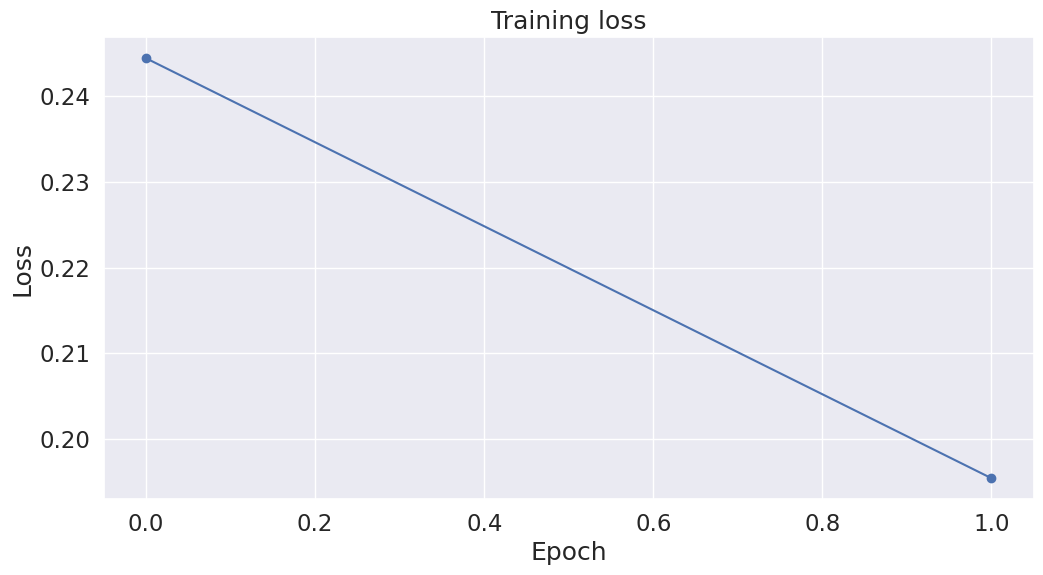

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

---

# **5. Evaluation**

In [30]:
df = pd.read_csv("en_fce_dev.tsv", delimiter='\t', header=None, names=['token', 'label'])

sentences = []
labels = []
unique_labels = set()


temp_sentences = []
temp_labels = []
for index, row in df.iterrows():
  if row["token"] != '.':
    temp_sentences.append(row['token'])
    temp_labels.append(row['label'])
    
  else:
    temp_sentences.append(row['token'])
    temp_labels.append(row['label'])
    
    unique_labels.add(row['label'])
    sentences.append(temp_sentences)
    labels.append(temp_labels)
    temp_labels = []
    temp_sentences = []


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    sent_str = ' '.join(sent)
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                  # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'][0])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'][0])

new_labels = []

null_label_id = -100

for sen, orig_labels in zip(input_ids, labels):
  padded_labels = []
  orig_labels_i = 0

  n = len(orig_labels)

  for token_id in sen:
    token_id = token_id.numpy().item()
    if (token_id == tokenizer.pad_token_id) or (token_id == tokenizer.cls_token_id) or (token_id == tokenizer.sep_token_id):
      padded_labels.append(null_label_id)
    #elif tokenizer.ids_to_tokens[token_id][0:2] == "##":
     # padded_labels.append(null_label_id)
    else:
      if orig_labels_i < n:
        padded_labels.append(label_map[orig_labels[orig_labels_i]])
        orig_labels_i += 1
  
  new_labels.append(padded_labels)

from keras.utils import pad_sequences

#input_ids = pad_sequences(input_ids, maxlen= 256, dtype= "long", value= 0, truncating= "post", padding= "post")
new_labels = pad_sequences(new_labels, maxlen= 256, dtype= "long", value= 0, truncating= "post", padding= "post")

# Convert the lists into PyTorch tensors.
pt_input_ids = torch.stack(input_ids, dim=0)
pt_attention_masks = torch.stack(attention_masks, dim=0)
pt_labels = torch.tensor(new_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)




/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [31]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(pt_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      result = model(b_input_ids, 
                       
                      attention_mask=b_input_mask,
                      return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


Predicting labels for 1,768 test sentences...


In [32]:
from sklearn.metrics import f1_score

# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

print("After flattening the batches, the predictions have shape:")
print("    ", all_predictions.shape)

# Next, let's remove the third dimension (axis 2), which has the scores
# for all 18 labels. 

# For each token, pick the label with the highest score.
predicted_label_ids = np.argmax(all_predictions, axis=2)

print("\nAfter choosing the highest scoring label for each token:", predicted_label_ids.shape) 

# Finally, for the sake of scoring, we don't actually care about the different
# sentences--we just look at whether the model made correct predictions for the
# individual tokens.

# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print("\nAfter flattening the sentences, we have predictions:", predicted_label_ids.shape)
print("\ntrue labels: ", all_true_labels.shape)


After flattening the batches, the predictions have shape:
     (1768, 256, 3)

After choosing the highest scoring label for each token: (1768, 256)

After flattening the sentences, we have predictions: (452608,)

true labels:  (452608,)


In [33]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []
real_token_labels = []

# For each of the input tokens in the dataset...
for i in range(len(all_true_labels)):

    # If it's not a token with a null label...
    if not all_true_labels[i] == -100:
        
        # Add the prediction and the ground truth to their lists.
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print("After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))


Before filtering out `null` tokens, length = 452,608
After filtering out `null` tokens, length = 37,273


In [34]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(real_token_labels, real_token_predictions) 
p = precision_score(real_token_labels, real_token_predictions) 
r = recall_score(real_token_labels, real_token_predictions) 

print ("F1 score: {:.4}".format(f1))
print ("Precision: {:.4}".format(p))
print ("Recall: {:.4}".format(r))

F1 score: 0.9544
Precision: 0.923
Recall: 0.988


# done

In [ ]:
#saving model
import os

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


# **6. Deploy**

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [ ]:
!pip install transformers

from transformers import BertForTokenClassification


In [ ]:
from transformers import BertTokenizer
import torch
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForTokenClassification.from_pretrained(output_dir)

In [ ]:
sent = input()
encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 64,           # Pad & truncate all sentences.
                        #pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
input_id = encoded_dict['input_ids']
    
    # And its attention mask (simply differentiates padding from non-padding).
attention_mask = encoded_dict['attention_mask']

input_id = torch.Tensor(input_id)
attention_mask = torch.Tensor(attention_mask)

bert_tokens = []
for i in input_id:
  for j in i:
    bert_tokens.append(tokenizer.ids_to_tokens[j.item()])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded = model_loaded.to(device)
input_id = input_id.to(device)
attention_mask = attention_mask.to(device)

predictions = []
with torch.no_grad():
  # Forward pass, calculate logit predictions
  outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

logits = outputs.logits

# Move logits and labels to CPU
logits = logits.detach().cpu().numpy()

# Store predictions and true labels
predictions.append(logits)

all_predictions = np.concatenate(predictions, axis=0)
predicted_label_ids = np.argmax(all_predictions, axis=2)
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)

#print(sent)
print(bert_tokens[1:-1])
print(predicted_label_ids[1:-1])

---

# **7. Submission**

In [ ]:
df = pd.read_csv("en_fce_test_unlabelled.tsv", delimiter='\t', header=None, names=['token'])

In [ ]:
df.head(20)

In [ ]:
df.shape

In [ ]:
sentences = []
temp_sentences = []
for index, row in df.iterrows():
  if row["token"] != '.':
    temp_sentences.append(row['token'])    
  else:
    if row['token'] == ' ':
      print("hello")
    temp_sentences.append(row['token'])
    sentences.append(temp_sentences)
    temp_sentences = []


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    sent_str = ' '.join(sent)
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                  # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'][0])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'][0])


In [ ]:
# Convert the lists into PyTorch tensors.
pt_input_ids = torch.stack(input_ids, dim=0)
pt_attention_masks = torch.stack(attention_masks, dim=0)


In [ ]:

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(pt_input_ids, pt_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [ ]:
# Prediction on unlabelled test set

print('Predicting labels for {:,} test sentences...'.format(len(pt_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()

  # Store predictions and true labels
  predictions.append(logits)


In [ ]:

# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)

print("After flattening the batches, the predictions have shape: ", all_predictions.shape)

# Next, let's remove the third dimension (axis 2), which has the scores
# for all 18 labels. 

# For each token, pick the label with the highest score.
predicted_label_ids = np.argmax(all_predictions, axis=2)

print("\nAfter choosing the highest scoring label for each token:", predicted_label_ids.shape) 

# Finally, for the sake of scoring, we don't actually care about the different
# sentences--we just look at whether the model made correct predictions for the
# individual tokens.

# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)

print("\nAfter flattening the sentences, we have predictions:", predicted_label_ids.shape)


In [ ]:
len(predicted_label_ids)

In [ ]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []

# For each of the input tokens in the dataset...
for i in range(len(all_true_labels)):      
      # Add the prediction and the ground truth to their lists.
      real_token_predictions.append(predicted_label_ids[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))


In [ ]:
output_label = []
for i in real_token_labels:
  if i == 1:
    output_label.append('c')
  else:
    output_label.append('i')


In [ ]:
output_label[35708]

In [ ]:
for i in range(35709, 41932):
  output_label.append('c')

In [ ]:
len(output_label)

In [ ]:
df['label'] = output_label

In [ ]:
df.head(50)

In [ ]:
df.to_csv('en_fce_output.txt', header= False, index= False, sep="\t")

In [ ]:
df

In [ ]:
import csv

with open('en_fce_unlabelled.tsv', newline='') as data:
  print(data)

In [ ]:
import pandas as pd
df = pd.read_csv("en_fce_test_unlabelled.tsv", skip_blank_lines=False, delimiter='\t', header=None, names=['token'])

In [ ]:
df.head(50)

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
tokenizer = BertTokenizer.from_pretrained("./model_save/", config=config)

# Load the saved fine-tuned model
model = BertForTokenClassification.from_pretrained("./model_save/", config=config)

# Copy the model to the GPU.
model.to(device)

---